## ML 207 Final Project ##
### Bug Bounty Price Recommendation Engine ###
### Github repo: https://github.com/ekotysh/bbrec_engine ###

**by Eduard Kotysh**

# Intro
---
In this project, I want to create an ML algorithm that guesses the bug bounty price range for a given vulnerability. 

**Problem:** Currently, there is a big challenge in the field of Security Disclosure in determining how much a bug bounty should cost or how much a researcher should get paid for their responsible disclosure. 

Each company tends to select its own price ranges for bug bounties based on the multitude of factors, such as: 
 - how much they can afford to pay (this often boils down to company size, revenue, etc.)
 - location of the company (major tech cities tend to pay more)
 - the type of vulnerability and the affected scope
 - the severity of vulnerability
 - how much they believe a bug should be worth (highly subjective)
 - others

**Goal:** Our goal for this project is to capture some of these factors in the dataset and create an ML algorithm that is able to accurately discern the price range of a given vulnerability based on some of these factors.

At the very minimum, the user should be able to supply the **Type of Vulnerability, and its Severity**, and the ML engine would guess the price range of how much it's worth. 

**Usability:** I forsee this will be used by companies as a recommendation engine API to determine how much they should pay for bug bounties and existing vulnerabilities that have occurred. This could be offered as a free service at first to gather data and improve the ML engine. Once the accuracy is sufficient, it could become a paid service.

## Data Gathering
We want to gather existing data on paid vulnerabilities. Ideally, we want to gather as much information about the vulnerability as possible (this would comprise our training/test dataset) and an actual price that was paid (this would be our target label). 

This is a fairly difficult dataset to obtain, since the information is quite sensitive and unless both, the company and the dev agreed to disclose the bounty report, this information is typically unavailable.

**To my knowledge, there are no public datasets available that include bug bounty reports and their corresponding paid rewards.**

To collect this data, I decided to write a custom crawler for HackerOne that scouts the site for disclosed bug reports (only a fraction of them is mutually disclosed) and intelligently extracts specific fields of each report using jQuery. jQuery is handy for finding DOM elements and extracting data from them. I used Apify webscraper api and built my own crawler code on top of it that you can find [here](https://raw.githubusercontent.com/ekotysh/bbrec_engine/main/crawler/apify_code.js).


Using this technique, **I was able to obtain 2415 records** after 4 hours of runtime. 


## Data Preparation & Analysis
###  1. Removing critical missing data ###
The initial data I crawled contained a lot of missing information. While some missing information is OK (such as report date or severity score) other information is absolutely essential (bounty price, company name, severity <i>rating</i>, weakness type, etc).

I wrote a python script (`prune-empty-rewards.py`) to search for rows with critical missing data and remove them from the dataset. After this step, **I ended up with 1342 rows of clean data.**


### 2. Dealing with non-critical missing data ###
The other fields that were sometimes missing were non-critical meaning that the ML algorithm should still be able to make a fairly accurate decision. Perhaps, it wouldn't be as accurate as if it were with this data present, but it wouldn't skew the training or become an outlier. 

For these fields, the key to success was selecting a consistent "No value" placeholder that ML algo can learn as a signle separate categorical option. I had to be careful not to introduce multiple categorical options that meant the same thing, because that would certainly confuse the algorithm.

To accomplish this, I wrote a script (`fix-nans.py`) to find instances where fields were missing in different forms (such as '---' or '-' or empty) and replace them with a single consistent 'No value' placeholder.


### 3. Enriching the Data ###
I wanted to supplement my data with additional information for accuracy.

From my prior experience with estimating bug bounties, I knew that **company's size and location were often considerable factors** that played into the bug bounty price. 

To add this information, I wrote a script (`enrich-data.py`) that used APIs: 
  - Crunchbase API (to get basic company data)
  - Companies API (to get revenue and location data)
  - Google Maps API (to lash the location to city/state/country consistently)

This allowed me to have a much richer dataset that consisted of:
  - Company Name
  - Company Size
  - Company Revenue
  - Company Location (City, State, Country)
  - Bounty Awarded ($$$)
  - Bounty Weakness (i.e. SQL Injection)
  - Bounty Report Title (Text)
  - Bounty Report Description (Text)
  - Severity Rating (Low, Medium, High, Critical)
  - Severity Score (0-10)
  - Report Date
  - URL

### 4. Analyzing the Data ###
**Open-Source data:** 

While looking at the data and the corresponding bounty payouts, I realized that there was a significant discreptency between Open Source Projects/Communities and For-Profit Organizations. The Open-Source projects often provided lower payouts for the same types/severity of vulnerability. 

I decided to manually label those projects as "Open Source", thus introducing a new binary column into my dataset. This way, my ML algorithm would take this into account and hopefully be more accurate in its decision making.

**Dates:** 

Another caviat is the representation of dates in ML dataset. After reading [this article](https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96), I decided to explode each date into separate categorical columns: Year, Month, Day, Min - that would help ML algo create better associations/decisions in the process. I wrote a script that went through my entire dataset and converted the date into these categorical columns: `explode-dates.py` script.

**Binarization:** 

Since we're dealing with a lot of categorical data, as long as the number of variations for each feature is not overwhelming, it is best to binarize each variation, so that decision trees have a way at analyzing which variations were important. I accomplished it using `pd.get_dummies` and passing it the specific columns I wanted to binarize, leaving out the `Description` column, which had to be handled differently, as otherwise, all of its values would be unique.


### 5. Machine Learning Methods & Error Analysis ###
**Price Ranges:** 

After running some preliminary results using just default Decision Trees, I noticed that I was getting very poor results (~13% accuracy). I went back to analyzing my data and wrote a script `analyze-bounties.py` to see how many unique bounty prices I have. I ended up with 235 different bounty prices (target labels) across a 1342-row dataset. The variety of target labels here is quite vast across a rather small dataset, so no wonder the accuracy is poor. 

Instead, I decided to split my bounty prices into ranges:
  - `$0-1000`
  - `$1000-2000`
  - `$2000-5000`
  - `$5000-10000`
  - `$10000 plus`

This way instead of 135 target labels, we only have 5, while still making it a usable MVP product for users.

This significantly improved the accuracy of decision trees to over 50%. 

**Vectorizing the Description (Tfidf vs Count):** 

I tried using both, <b>tf-idf</b> and <b>count</b> vectorizers on description to see how they perform. While they both transform text into numeric form useful for machine learning models, the CountVectorizer simply produces the frequency of each token with respect to the index in the vocabulary. However, the **TfidfVectorizer hints at the overall originality** of the word by counting how many times it appears in the document vs the number of documents that token appears in.

I visualized the decision tree diagrams at multiple maxdepths for both vectorizers and found that in the case of using plain CountVectorizer, the tree tends to overfit right away, as I see some leafs containing company-specific terms from description like "dropbox" for example. Using tfidf produced much more original results and slightly better accuracy (by ~0.05).

**Decision Tree Tuning:**

At first attempt, I used the `DecisionTreeClassifier` without any params and it performed quite poorly (0.58 accuracy). It was clearly overfitting, because the training set accuracy was 1. To fix this, I decided to go the pre-prunning route and restrict the maximum depth of the tree to 3 or 4. 
To see what was happening with the tree exactly, I found a `graphviz` library I could use to save the tree to a .dot file and plot it visually.

- **With depth=3**, our trainset accuracy dropped to 0.695, but our test accuracy improved significantly from 0.58 -> to 0.6965, which told to me that it is overfitting much less over train data than it was before. 
Inspecting the tree tests visually, the decision chain made sense:
1. First, it started with checking whether severity is over 9.5 (since this immediately drops us into a much larger category of bounties).
2. If severity score was less than 9.5, the next test it chose was to see if the severity <i>rating</i> was higher than Low. This also makes sense, as it's now testing the lower bound to see just how low the bug severity is.
3. If severity score was 9.5 or higher, then the follow-up tests included checking the Description for important clues as to what type of vulnerability it is. For example, in one of the tests, it's checking for `__priveleg` hinting at the fact that when Privilige escalation has occured, it warrants the highest payout label.
(Refer to the diagram for the full tree visualization).

- **With depth=4**, I then decided to try depth=4, which would make the tree more complex, possibly give us a higher score, but may overfit more. The trainset accuracy improved to 0.71, while the test accuracy dropped from 0.695 (at depth=3) -> to 0.683. This immediately hints at overfitting from depth=3, since the test score went down, while train score went up. 
I decided to look at the visual tree just to see what it came up with, and as expected, we see that at level 4 the tree starts making decisions off terms like "dropbox" and "summary", which are not really important in the overall decision making about bug bounty price or severity. 
<br></br>

**Bringing it Together Using Pipeline**:

I wanted to join the results of my vectorized description with the results of Decision Tree classifier on other fields. This way, the Decision Tree takes into account all binarized features, together with tfdif'd description features. 

I was able to find a `make_pipeline` function that allowed me put it all together like this:
```
tree = DecisionTreeClassifier(max_depth=maxdepth, random_state=42)
ct1 = make_column_transformer((cv_desc, 'Report Description'), remainder='passthrough')
pipeline = make_pipeline(ct1, tree)
pipeline.fit(train_X, train_Y)
```


This performs column vectorization transformation over Description, while allowing other columns to 'passthrough' to the DecisionTreeClassifier without change. Then, decision tree takes them all together and analyzes.
<br></br>
### 6. Future Improvements ###

- Get more data (5000-10000 records)
- Look into joining `Weakness` and `Title` into the Pipline, along with Description
- More detailed tuning with Random Forest classifier
- Try post-pruning techniques instead of pre-pruning



In [9]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Confusion matrix, classification report
from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn import metrics
from sklearn.metrics import classification_report

# Decision trees and Random Forest
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Decision tree diagrams.
import graphviz
from sklearn.tree import export_graphviz

# Pipelining vectorized column into other data
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

# Feature extraction from text
from sklearn.feature_extraction.text import *

# Stop words and stemming
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Pretty print
from pprint import pprint
from tabulate import tabulate



Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
dataset_file = 'https://raw.githubusercontent.com/ekotysh/bbrec_engine/main/dataset/final_bb_dataset_with_ranges.csv'


header_names = ['Company Name', 'Company Size', 'Open Source', 'Company Revenue',
              'Bounty Awarded', 'Severity Rating', 'Severity Score', 'Weakness',
              'Report Title', 'Report Description', 'URL', 
              'Company State', 'Company Country', 'Company City',
              'Report Year', 'Report Month', 'Report Day', 'Report Hour', 'Report Minute',
              'Bounty Ranges']

# Read the csv in from my github repo
df = pd.read_csv(dataset_file, names=header_names)

# Remove the dollar sign from bounties
# df["Bounty Awarded"] = df["Bounty Awarded"].replace({'\$':''}, regex = True)

# Get the target labels (our bug bounty prices)
labels = df.loc[:,"Bounty Ranges"]


In [3]:
def remove_stop_words(s):
  # combine english, russian and custom non-words
  non_words = {'hi', 'hello', 'pleas', 'like', 'bug', 'bounty', 'bounti', 'nov', 'oct', 
               'ago', 'think', 'thank', 'need', 'howev', 'year hi', 'year hello', 'thank report'}
  stop_words = set(stopwords.words('english')).union(set(stopwords.words('russian'))).union(non_words)
  clean_words = []  # keep track of only clean words (non-stop)
  tokenized_str = word_tokenize(s)
  # go through each token and add it to clean if it's not a stop word
  for word in tokenized_str:
    if word not in stop_words:
      clean_words.append(word)

  # convert from list back to string
  clean_str = ' '.join(clean_words)
  return clean_str 

def remove_numbers(s):
  # go through any sequence of numbers and replace them with nnn using regex
  pattern = '[0-9]+'
  repl = 'nnn'
  return re.sub(pattern, repl, s)

def remove_apostophes(s):
  # replace the occurences of two different types of apostrophes (' & ’) with an empty space
  pattern1 = "(?<=[a-z])'(?=[a-z])"
  repl = ' '
  pattern2 = "(?<=[a-z])’(?=[a-z])"
  s1 = re.sub(pattern1, repl, s)
  return re.sub(pattern2, repl, s1)

def add_stems(s):
  # for each word, return a stem instead
  ps = PorterStemmer()
  stems = ""
  tokenized_str = word_tokenize(s)  # tokenize the string
  for word in tokenized_str:
    stems = stems + " " + ps.stem(word)

  # only return stems
  return stems

# preprocessor for vectorizing text fields
def text_preprocessor(s):
  s = remove_numbers(s)
  s = remove_apostophes(s) 
  s = remove_stop_words(s)
  s = add_stems(s) 
  s = s.lower()
  return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Vectorizing Description column using Tfidf ngram=(1, 1)...
	Tfidf'd Description vocabulary: ['______________nnn' '__cfduid' '__interceptor_malloc' ... 'ценим' 'что'
 'это']
	Size of vocabulary: 6305
	Fraction of Non-zero entries: 0.014288985951098778

Building a Decision Tree Pipeline with MaxDepth=3...
	Overall Accuracy (train): 0.6953937592867756
	Overall Accuracy (test): 0.6965620328849028

	Exporting tree diagram...


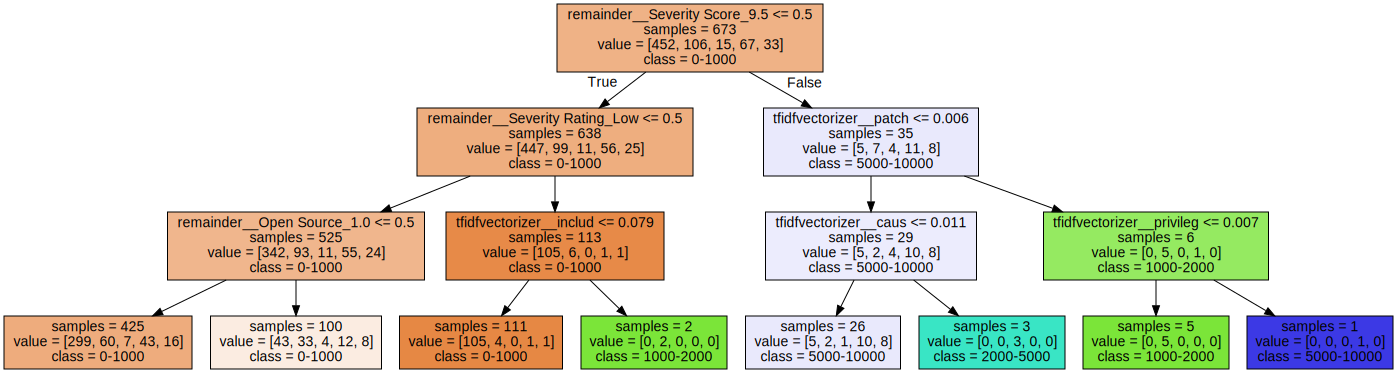


Building a Decision Tree Pipeline with MaxDepth=4...
	Overall Accuracy (train): 0.7102526002971769
	Overall Accuracy (test): 0.6831091180866966

	Exporting tree diagram...


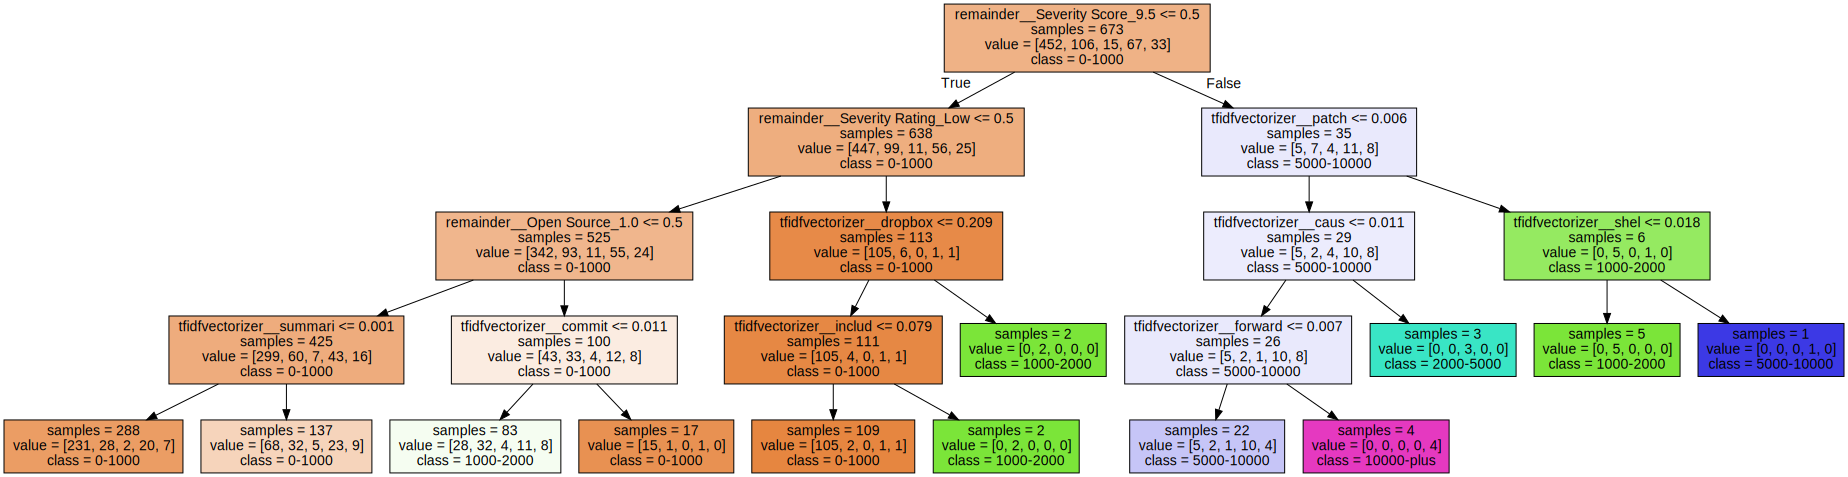


Building a Random Forest Pipeline...
	Overall Accuracy (train): 1.0
	Overall Accuracy (test): 0.6980568011958147

Predicting Custom Bug Reports...


Predictions:
╒═════════════════════════════════════════════╤═════════════════════════════╕
│ Bug Report:                                 │ Predicted Bug Bounty $$$:   │
╞═════════════════════════════════════════════╪═════════════════════════════╡
│ Company Size_1001-5000: 1                   │ $10000-plus                 │
│ Severity Rating_High: 1                     │                             │
│ Weakness_Business Logic Errors: 1           │                             │
│ Company State_California: 1                 │                             │
├─────────────────────────────────────────────┼─────────────────────────────┤
│ Company Size_1001-5000: 1                   │ $0-1000                     │
│ Severity Rating_Low: 1                      │                             │
│ Weakness_Business Logic Errors: 1           │          

In [26]:
class BugReport:

  no_value = "No value"
  company_size = no_value
  open_source = 0.0
  severity_rating = no_value
  severity_score = no_value
  weakness = no_value
  description = no_value
  company_state = no_value 
  company_country = no_value
  company_city = no_value
  report_year = no_value
  report_month = no_value
  report_day = no_value

  def __init__(self, company_size=no_value, open_source=0.0, severity_rating=no_value, severity_score=no_value,
               weakness=no_value, description=no_value, company_state=no_value, company_country=no_value, company_city=no_value,
               report_year=no_value, report_month=no_value, report_day=no_value):
    
    self.company_size = company_size
    self.open_source = open_source
    self.severity_rating = severity_rating
    self.severity_score = severity_score
    self.weakness = weakness
    self.description = description
    self.company_state = company_state
    self.company_country = company_country
    self.company_city = company_city
    self.report_year = report_year
    self.report_month = report_month
    self.report_day = report_day

  def tolist(self):
    return [self.company_size, self.open_source, self.severity_rating, self.severity_score,
            self.weakness, self.description, self.company_state, self.company_country,
            self.company_city, self.report_year, self.report_month, self.report_day]


def vectorize_column(name, column, min_df_val, ngram_start, ngram_end):
  print(f"Vectorizing Description column using Tfidf ngram=({ngram_start}, {ngram_end})...")
  # tokenize by word + remove words that appear in fewer than min_df_val documents.
  #cv = CountVectorizer(min_df=min_df_val, preprocessor=text_preprocessor)
  cv = TfidfVectorizer(min_df=min_df_val, ngram_range=(ngram_start, ngram_end),
                       preprocessor=text_preprocessor)

  vectorized = cv.fit_transform(column)
  feature_names = cv.get_feature_names_out()

  print(f"\tTfidf'd {name} vocabulary: {feature_names}")
  print("\tSize of vocabulary:", feature_names.shape[0])
  print("\tFraction of Non-zero entries:", vectorized.nnz / (vectorized.shape[0]*vectorized.shape[1]))
  print("")
  return cv

def run_random_forest(ct1, train_X, test_X, train_Y, test_Y):

  # Random Forest Pipeline:
  print("Building a Random Forest Pipeline...")
  pipeline = make_pipeline(ct1, RandomForestClassifier())

  pipeline.fit(train_X, train_Y)
  score_train = pipeline.score(train_X, train_Y)
  score_test  = pipeline.score(test_X, test_Y)

  print("\tOverall Accuracy (train):", score_train) 
  print("\tOverall Accuracy (test):", score_test)
  print("")

def run_decision_tree(maxdepth, ct1, train_X, test_X, train_Y, test_Y):

  # Decision Tree Pipeline:
  print(f"Building a Decision Tree Pipeline with MaxDepth={maxdepth}...")
  tree = DecisionTreeClassifier(max_depth=maxdepth, random_state=42)
  pipeline = make_pipeline(ct1, tree)
  pipeline.fit(train_X, train_Y)
  score_train = pipeline.score(train_X, train_Y)
  score_test  = pipeline.score(test_X, test_Y)
  
  #pred_y = tree.predict(test_X)
  #results = confusion_matrix(test_Y, pred_y)
  #error = zero_one_loss(test_Y, pred_y)

  print("\tOverall Accuracy (train):", score_train)
  print("\tOverall Accuracy (test):", score_test)
  print("")

  print("\tExporting tree diagram...")
  export_graphviz(tree, out_file="tree.dot", 
                  class_names=['0-1000', '1000-2000', '2000-5000', '5000-10000', '10000-plus'],
                  feature_names=ct1.get_feature_names_out(),
                  impurity=False, filled=True)
  
  with open("tree.dot") as f:
    dot_graph = f.read()
  
  display(graphviz.Source(dot_graph))
  print("")


def predict_custom_bugreports(desc_transformer, train_X, train_Y, bugreports_df):
  print("Predicting Custom Bug Reports...")
  print("")

  pipeline = make_pipeline(desc_transformer, RandomForestClassifier())

  pipeline.fit(train_X, train_Y)

  preds = pipeline.predict(bugreports_df)

  custom_reports = []
  idx = 0
  for index, row in bugreports_df.iterrows():
    report = ""
    for col in bugreports_df.columns:
      if row[col] != 0 and re.search('Severity Rating|Weakness|Company Size|Company State', col):
        report += f"{col}: {row[col]}\n"
    
    custom_reports.append([report, "$" + preds[idx]])
    idx += 1

  print("")
  print("Predictions:")
  data = []
  print(tabulate(custom_reports, headers=["Bug Report:", "Predicted Bug Bounty $$$:"], tablefmt='fancy_grid'))


def main():
  # Note: 'Company Revenue' actually hurts accuracy
  #'Weakness', 'Report Title', 'Report Description',
  train_columns = ['Company Size', 'Open Source', 
                'Severity Rating', 'Severity Score', 'Weakness', 
                'Report Description', 
                'Company State', 'Company Country', 'Company City',
                'Report Year', 'Report Month', 'Report Day']

  # Pick the columns we're gonna train/test with
  clean_df = df[train_columns]
  
  # convert categorical columns into binary features
  binarized_df = pd.get_dummies(clean_df, columns=binarize_columns, drop_first=True)

  # Split our dataset in half - 50% train / 50% test
  mid_point = int(binarized_df.shape[0] / 2) + 1

  # Get our train and test datasets with respective labels
  train_df = binarized_df[1:mid_point]
  test_df  = binarized_df[mid_point:binarized_df.shape[0]-4]

  train_labels = labels[1:mid_point]
  test_labels = labels[mid_point:labels.shape[0]-4]

  # The last two rows are custom bug reports we want to try and predict
  custom_bugreports_df = binarized_df[binarized_df.shape[0]-4:binarized_df.shape[0]]
  
  # Show all training columns
  # pprint(train_df.columns.tolist())

  # Vectorize textual fields
  # tokenize by word + remove words that appear in fewer than 20 documents.
  #cv_titl = vectorize_column("Title",       clean_df['Report Title'], 5)
  #ct_titl = make_column_transformer((cv_titl, 'Report Title'), remainder='passthrough')
  cv_desc = vectorize_column("Description", clean_df['Report Description'], 2, 1, 1)
  ct_desc = make_column_transformer((cv_desc, 'Report Description'), remainder='passthrough')
  
  # Run a Decision Tree (max-depth=3) in a pipeline with Tfidf'd description 
  run_decision_tree(3, ct_desc, train_df, test_df, train_labels, test_labels)

  # Run a Decision Tree (max-depth=4) in a pipeline with Tfidf'd description 
  run_decision_tree(4, ct_desc, train_df, test_df, train_labels, test_labels)

  # Run a Random Forest classifier in a pipeline with Tfidf'd description 
  run_random_forest(ct_desc, train_df, test_df, train_labels, test_labels)

  # Try Predicting several custom bug reports 
  predict_custom_bugreports(ct_desc, train_df, train_labels, custom_bugreports_df);


# download stopwords and punkt for nltk
nltk.download('stopwords')
nltk.download('punkt')
print()

pd.set_option('display.max_columns', None)

binarize_columns = ['Company Size', 'Open Source',  
                    'Severity Rating', 'Severity Score', 'Weakness', 
                    'Company State', 'Company Country', 'Company City',
                    'Report Year', 'Report Month', 'Report Day']

main()

 ----------

-------------------

-------------------